1. Importação de Bibliotecas e Dados

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

#eliminar warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [2]:
import pandas as pd

# Carregando os dados
equipamentos_df = pd.read_excel('Dados/23w06_Equipamentos.xlsx')
series_temporais_df = pd.read_excel('Dados/23w06_SeriesTemporais_Horimetros.xlsx')

In [6]:
#merged_df = pd.merge(series_temporais_df, equipamentos_df, left_on='Chassis Id*', right_on='Chassis ID', how='left')

2. Análise Exploratória dos Dados

In [4]:
equipamentos_df.info()
series_temporais_df.info()

equipamentos_df.describe(include='all')
series_temporais_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Região         63 non-null     object        
 1   País           63 non-null     object        
 2   Dealer         63 non-null     object        
 3   Segmento       63 non-null     object        
 4   Modelo         63 non-null     object        
 5   Chassis ID     63 non-null     object        
 6   PIN17          57 non-null     object        
 7   Delivery Date  62 non-null     datetime64[ns]
 8   Obs.:          15 non-null     object        
 9   Estado         63 non-null     object        
 10  Região.1       63 non-null     object        
dtypes: datetime64[ns](1), object(10)
memory usage: 5.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118161 entries, 0 to 118160
Data columns (total 3 columns):
 #   Column                            Non-Null Count   Dtype   

,Machine History Date Day,Compensated Working Hours By Day
count,118161,118161.000000
mean,2019-12-29 02:52:04.624876288,5.803329
min,2012-08-17 00:00:00,0.000000
25%,2018-06-28 00:00:00,0.038235
50%,2020-05-21 00:00:00,4.200000
75%,2021-10-19 00:00:00,9.200000
max,2023-02-08 00:00:00,85.450000
std,NaN,6.365152


In [7]:
# Merge the two dataframes based on the chassis ID
merged_df = pd.merge(equipamentos_df[['Chassis ID', 'Delivery Date']],
                     series_temporais_df[['Chassis Id*', 'Machine History Date Day']],
                     left_on='Chassis ID', right_on='Chassis Id*', how='inner')

# Calculate the difference in days between the two dates
merged_df['Difference in Days'] = (merged_df['Machine History Date Day'] - merged_df['Delivery Date']).dt.days

# Display the first few rows of the merged data
merged_df.head()

,Chassis ID,Delivery Date,Chassis Id*,Machine History Date Day,Difference in Days
0,A040F320538,2020-11-26,A040F320538,2016-12-14,-1443.0
1,A040F320538,2020-11-26,A040F320538,2016-12-15,-1442.0
2,A040F320538,2020-11-26,A040F320538,2016-12-16,-1441.0
3,A040F320538,2020-11-26,A040F320538,2016-12-17,-1440.0
4,A040F320538,2020-11-26,A040F320538,2016-12-18,-1439.0


In [8]:
# Count the number of negative date differences
negative_dates_count = merged_df[merged_df['Difference in Days'] < 0].shape[0]
negative_dates_count

2105

In [9]:
# Calculate the sum of 'Compensated Working Hours By Day' for each 'Chassis ID'
sum_hours_by_chassis = series_temporais_df.groupby('Chassis Id*')['Compensated Working Hours By Day'].sum().reset_index()

# Merge this sum with the merged_df to add the total working hours for each 'Chassis ID'
merged_df_with_sum = pd.merge(merged_df, sum_hours_by_chassis, on='Chassis Id*', how='left')

# Rename the columns for clarity
merged_df_with_sum.rename(columns={'Compensated Working Hours By Day': 'Total Working Hours By Chassis'}, inplace=True)

# Display the first few rows of the updated data
merged_df_with_sum.head()

,Chassis ID,Delivery Date,Chassis Id*,Machine History Date Day,Difference in Days,Total Working Hours By Chassis
0,A040F320538,2020-11-26,A040F320538,2016-12-14,-1443.0,6465.842789
1,A040F320538,2020-11-26,A040F320538,2016-12-15,-1442.0,6465.842789
2,A040F320538,2020-11-26,A040F320538,2016-12-16,-1441.0,6465.842789
3,A040F320538,2020-11-26,A040F320538,2016-12-17,-1440.0,6465.842789
4,A040F320538,2020-11-26,A040F320538,2016-12-18,-1439.0,6465.842789


In [10]:
# For rows with negative date differences, update the 'Delivery Date' to be the same as 'Machine History Date Day'
mask_negative_dates = merged_df_with_sum['Difference in Days'] < 0
merged_df_with_sum.loc[mask_negative_dates, 'Delivery Date'] = merged_df_with_sum.loc[mask_negative_dates, 'Machine History Date Day']

# Recalculate the 'Difference in Days' column after updating the 'Delivery Date'
merged_df_with_sum['Difference in Days'] = (merged_df_with_sum['Machine History Date Day'] - merged_df_with_sum['Delivery Date']).dt.days

# Display the first few rows of the updated data
merged_df_with_sum.head()


,Chassis ID,Delivery Date,Chassis Id*,Machine History Date Day,Difference in Days,Total Working Hours By Chassis
0,A040F320538,2016-12-14,A040F320538,2016-12-14,0.0,6465.842789
1,A040F320538,2016-12-15,A040F320538,2016-12-15,0.0,6465.842789
2,A040F320538,2016-12-16,A040F320538,2016-12-16,0.0,6465.842789
3,A040F320538,2016-12-17,A040F320538,2016-12-17,0.0,6465.842789
4,A040F320538,2016-12-18,A040F320538,2016-12-18,0.0,6465.842789


In [18]:
# Calculate the cumulative sum of 'Compensated Working Hours By Day' for each 'Chassis ID' up to the specific date
series_temporais_df.sort_values(by=['Chassis Id*', 'Machine History Date Day'], inplace=True)
series_temporais_df['Cumulative Working Hours'] = series_temporais_df.groupby('Chassis Id*')['Compensated Working Hours By Day'].cumsum()

# Merge this cumulative sum with the merged_df_with_sum to update the 'Total Working Hours By Chassis' column
merged_df_updated = pd.merge(merged_df_with_sum.drop('Total Working Hours By Chassis', axis=1), 
                             series_temporais_df[['Chassis Id*', 'Machine History Date Day','Compensated Working Hours By Day', 'Cumulative Working Hours']], 
                             on=['Chassis Id*', 'Machine History Date Day'], 
                             how='left')

# Rename the column for clarity
merged_df_updated.rename(columns={'Cumulative Working Hours': 'Total Working Hours By Chassis Until Date'}, inplace=True)

# Display the first few rows of the updated data
merged_df_updated.head(10)

,Chassis ID,Delivery Date,Chassis Id*,Machine History Date Day,Difference in Days,Compensated Working Hours By Day,Total Working Hours By Chassis Until Date
0,A040F320538,2016-12-14,A040F320538,2016-12-14,0.0,0.00,0.00
1,A040F320538,2016-12-15,A040F320538,2016-12-15,0.0,0.00,0.00
2,A040F320538,2016-12-16,A040F320538,2016-12-16,0.0,0.05,0.05
3,A040F320538,2016-12-17,A040F320538,2016-12-17,0.0,0.05,0.10
4,A040F320538,2016-12-18,A040F320538,2016-12-18,0.0,0.05,0.15
5,A040F320538,2016-12-19,A040F320538,2016-12-19,0.0,0.05,0.20
6,A040F320538,2016-12-20,A040F320538,2016-12-20,0.0,0.05,0.25
7,A040F320538,2016-12-21,A040F320538,2016-12-21,0.0,0.05,0.30
8,A040F320538,2016-12-22,A040F320538,2016-12-22,0.0,0.15,0.45
9,A040F320538,2016-12-23,A040F320538,2016-12-23,0.0,0.20,0.65


In [25]:
# mostrar valores unicos do Chassis ID
merged_df_updated['Chassis ID'].unique()

array(['A040F320538', 'A30G732052', 'A30G732029', 'EC210282764',
       'EC210282811', 'EC220245052', 'L60F072447', 'L60F073176',
       'L60F073972', 'A30G732028', 'A30G732035', 'A30G732079',
       'EC220240448', 'EC220245261', 'EC220245288', 'L60F072286',
       'L60F074089', 'L60F074121', 'A30F072882', 'A45G332087',
       'A45G332090', 'EC210240111', 'EC220240109', 'EC220240341',
       'L60F072205', 'L60F072640', 'L60F074213', 'A030F720057',
       'A30F072791', 'A30G732008', 'EC220245244', 'EC220245461',
       'EC220245239', 'L60F073321', 'L60F073882', 'L60F074104',
       'A30F072964', 'A30F072956', 'A30F072792', 'EC220240605',
       'EC220245238', 'EC220245388', 'EC220240814', 'L60F072957',
       'L60F073325', 'L60F073726', 'A30F072960', 'A45G332092',
       'EC220240223', 'EC220245253', 'L60F071852', 'L60F072499',
       'L60F072903', 'A040F320657', 'A040F320672', 'A40G341530',
       'EC220240477', 'EC220240485', 'EC220245079', 'L60F007228',
       'L60F072664', 'L60F0730

<Axes: xlabel='Difference in Days'>

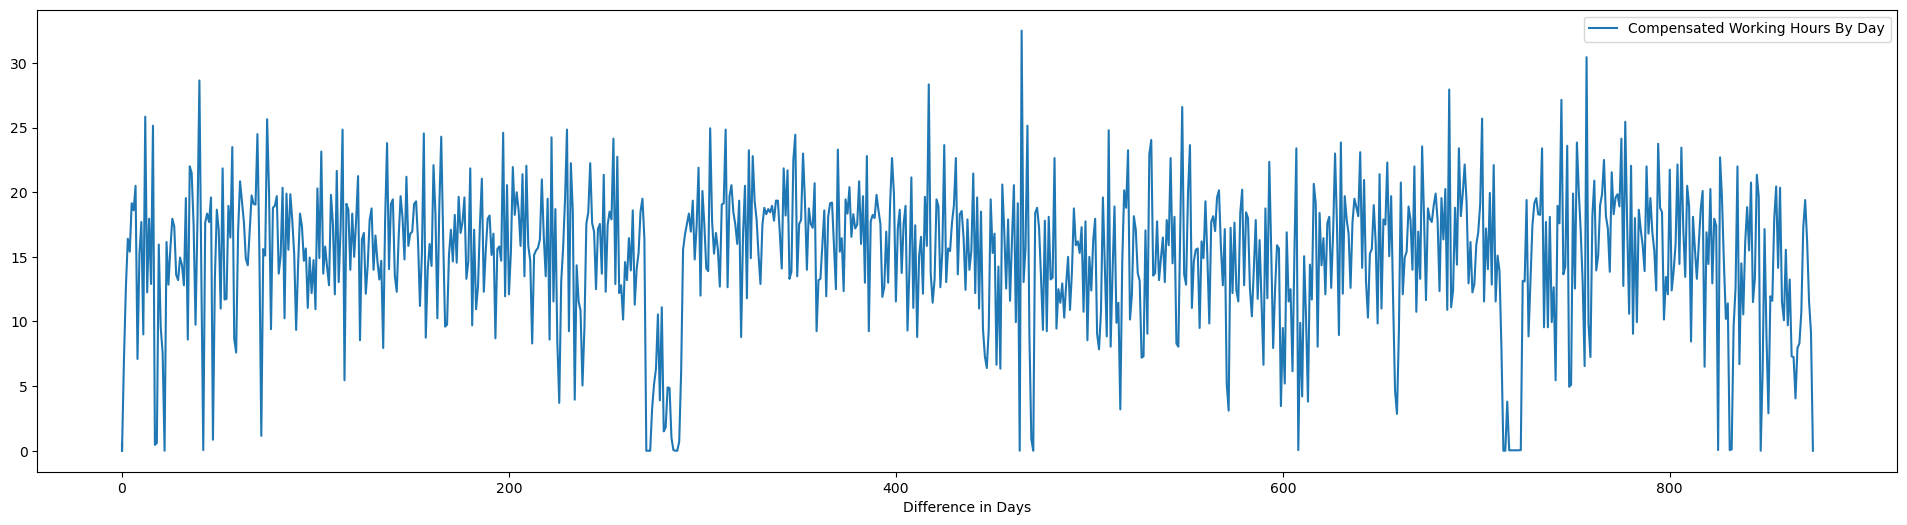

In [33]:
#Fazer grafico de linha com Compensated Working Hours By Day e Total Working Hours By Chassis Until Date para um Chassis ID
# Create a mask to filter the data for a specific chassis ID
mask_chassis_id = merged_df_updated['Chassis Id*'] == 'L60F073972'

# Create a line plot of the two columns for the specific chassis ID
merged_df_updated[mask_chassis_id].plot(x='Difference in Days', y=['Compensated Working Hours By Day'
                                                                   #, 'Total Working Hours By Chassis Until Date'
                                                                   ], figsize=(24,6))